# 06 — Results Aggregation and Statistical Testing

This notebook will aggregate JSON reports, summary tables and statistical analyses of the models.

In [13]:
import pandas as pd, json, glob
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

files = glob.glob("../results/models/*.json", recursive=True)
records = []
for f in files:
    if "regression" not in f.lower():   
        continue
    with open(f) as j:
        d = json.load(j)
        d["model"] = Path(f).stem.replace("_test_report","") 
        records.append(d)
df = pd.DataFrame(records)
df.head()

,r2_score,adjusted_r2,mae,mse,rmse,pearson_r,model
0,0.796172,0.796172,0.042927,0.002745,0.052394,0.916207,DecisionTree_regression_regression_report
1,0.796172,0.796172,0.042927,0.002745,0.052394,0.916207,DecisionTree_regression
2,0.805847,0.805847,0.040873,0.002615,0.051135,0.912658,kNN_regression_regression_report
3,0.805847,0.805847,0.040873,0.002615,0.051135,0.912658,kNN_regression
4,0.933420,0.933420,0.024747,0.000897,0.029945,0.976390,RandomForest_regression_regression_report


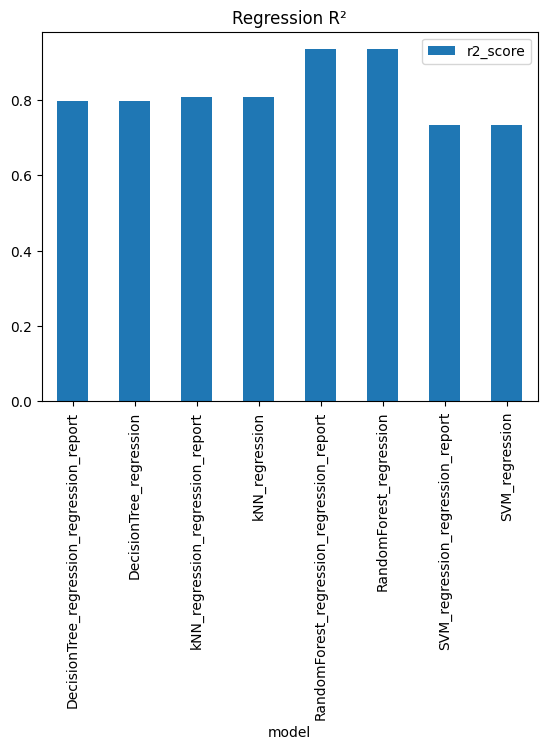

In [14]:
# Plot summary bars for classification accuracy and regression R²
reg = df[df["model"].str.contains("regression")]
reg.plot.bar(x="model", y="r2_score", title="Regression R²")
plt.show()

In [22]:
# ---- Load CV JSONs for regression models ----
def load_cv_scores(model_name, metric_key="cv_r2_per_fold", base_dir="../results/models"):
    """Utility to load per-fold CV scores or fall back to single summary value."""
    path = Path(base_dir) / f"{model_name}_cv.json"
    if not path.exists():
        raise FileNotFoundError(f"No CV file found for {model_name} in {base_dir}")
    with open(path) as f:
        d = json.load(f)
    # Prefer per-fold scores if present, otherwise wrap single value
    return d.get(metric_key) or [d.get("cv_f1_macro") or d.get("cv_r2_mean")]

# Example: compare regression CV R² between RandomForest and SVM
rf_cv = load_cv_scores("RandomForest_Regression", metric_key="cv_r2_per_fold")
svm_cv = load_cv_scores("SVM_Regression", metric_key="cv_r2_per_fold")

print("RF per-fold:", rf_cv)
print("SVM per-fold:", svm_cv)

# ---- Paired t-test ----
if len(rf_cv) == len(svm_cv) and len(rf_cv) > 1:
    t, p = ttest_rel(rf_cv, svm_cv)
    print(f"Paired t-test (RF vs SVM): t={t:.3f}, p={p:.3f}")
else:
    print("⚠️  Not enough per-fold values for t-test (need ≥2 and equal length).")


RF per-fold: [0.7698557403918664, 0.8075106693501437, 0.7895764979536288, 0.6708366287678562, 0.7071514188816529]
SVM per-fold: [0.4856975399525615, 0.7419039979556681, 0.6907941288305635, 0.4316139453690687, 0.548121046684584]
Paired t-test (RF vs SVM): t=4.113, p=0.015
